Make synthetic worm datasets containing sinusoidal signals and visualize them.

In [1]:
from preprocess._utils import smooth_data_preprocess, reshape_calcium_data
from utils import NEURONS_302
from sklearn.preprocessing import StandardScaler
import numpy as np
import pickle
import random


def create_synthetic_dataset(
    max_timesteps,
    num_signal,
    num_worms,
    if_noise=False,
    sum_frequencies=0,
    freq_gain=1,
    neuron_correlation=False,
    noise_sd=0.02,
    transform=StandardScaler(),
):
    """
    Create synthetic worm datasets using a combination of sine and cosine functions.

    :param seq_len: The sequence length of the synthetic data.
    :param num_signal: The number of signals, corresponds to number of neurons.
    :param num_worms: The number of worms to create datasets for.
    :param if_noise: If true, add Gaussian noise to the synthetic data.
    :param sum_frequencies: The number of sine/cosine functions to add together to create a signal.
    :param gain: A multiplier for the frequencies of the calcium signal.
    :param neuron_correlation: If true, creates a correlated signal across neurons.
    :param noise_sd: Standard deviation of the Gaussian noise.
    :param noise_sd: sklearn transform to use for normalizing the data.
    :return: A dictionary containing the synthetic worm datasets.
    """
    dataset = {}
    time_in_seconds = np.arange(max_timesteps).reshape(-1, 1)  # Column vector
    half_num_signal = num_signal // 2

    for worm_idx in range(num_worms):
        worm_data = {}
        calcium_data = np.zeros((max_timesteps, half_num_signal))
        time_points = np.arange(max_timesteps)
        neuron_names = np.array(random.sample(NEURONS_302, half_num_signal))

        # Create neuron to idx mapping and vice versa
        neuron_to_idx = {neuron: idx for idx, neuron in enumerate(neuron_names)}
        idx_to_neuron = {idx: neuron for neuron, idx in neuron_to_idx.items()}

        for i in range(half_num_signal):
            frequencies = [
                freq_gain
                * np.random.uniform(1.0 / max_timesteps, 5 * 1.0 / max_timesteps)
                for _ in range(sum_frequencies + 1)
            ]
            phases = [
                np.random.random() * 2 * np.pi for _ in range(sum_frequencies + 1)
            ]

            if neuron_correlation:
                frequencies[0] = 1.0 / max_timesteps * (i + 1)

            for freq, phase in zip(frequencies, phases):
                calcium_data[:, i] += np.sin(2 * np.pi * freq * time_points + phase)

            if if_noise:
                calcium_data[:, i] += np.random.normal(0, noise_sd, max_timesteps)

        # normalize data
        calcium_data = transform.fit_transform(calcium_data)

        smooth_calcium_data = smooth_data_preprocess(
            calcium_data, time_in_seconds, "FFT"
        )
        dt = np.gradient(time_in_seconds, axis=0)
        dt[dt == 0] = np.finfo(float).eps
        residual_calcium = np.gradient(calcium_data, axis=0) / dt
        smooth_residual_calcium = smooth_data_preprocess(
            residual_calcium, time_in_seconds, "FFT"
        )

        worm_data["calcium_data"] = calcium_data
        worm_data["residual_calcium"] = residual_calcium
        worm_data["smooth_calcium_data"] = smooth_calcium_data
        worm_data["smooth_residual_calcium"] = smooth_residual_calcium
        worm_data["time_in_seconds"] = time_in_seconds
        worm_data["dt"] = dt
        worm_data["max_timesteps"] = max_timesteps
        worm_data["neuron_to_idx"] = neuron_to_idx
        worm_data["idx_to_neuron"] = idx_to_neuron
        worm_data["num_neurons"] = half_num_signal
        worm_data["num_named_neurons"] = half_num_signal
        worm_data["num_unknown_neurons"] = 0  # No unknown neurons in this case

        worm_data = reshape_calcium_data(worm_data)

        dataset[f"worm{worm_idx}"] = worm_data

    return dataset


def save_synthetic_dataset(file_name, datasets):
    with open(file_name, "wb") as f:
        pickle.dump(datasets, f)


max_timesteps = 3312
num_signal = 302
num_worms = 10

# Creating and saving datasets
dataset = create_synthetic_dataset(
    max_timesteps,
    num_signal,
    num_worms,
    if_noise=True,
    sum_frequencies=8,
    freq_gain=100,
    neuron_correlation=True,
    noise_sd=0.02,
)
save_synthetic_dataset("../data/processed/neural/Synthetic0000.pickle", dataset)


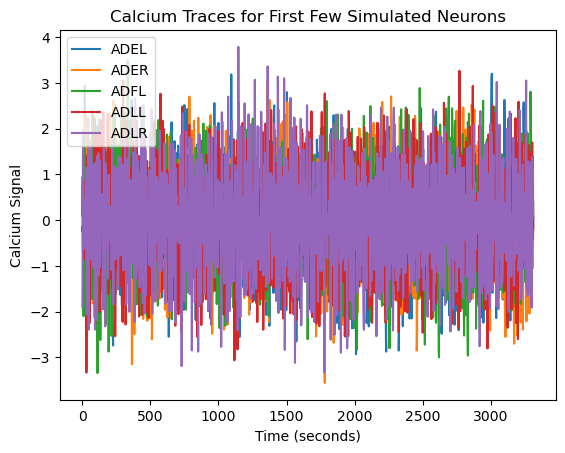

In [2]:
import matplotlib.pyplot as plt


def plot_synthetic_data(worm_data, num_neurons=5):
    """
    Plot the calcium traces for a given worm's data.

    :param worm_data: The data for a single worm from the synthetic dataset.
    :param num_neurons: The number of neurons to plot.
    """

    calcium_data = worm_data["calcium_data"]
    time_seconds = worm_data["time_in_seconds"]
    slot_to_named_neuron = worm_data["slot_to_named_neuron"]

    for neuron_idx in range(num_neurons):
        neuron_name = slot_to_named_neuron.get(neuron_idx, "no data")
        if neuron_name != "no data":
            plt.plot(time_seconds, calcium_data[:, neuron_idx], label=neuron_name)

    plt.xlabel("Time (seconds)")
    plt.ylabel("Calcium Signal")
    plt.title("Calcium Traces for First Few Simulated Neurons")
    plt.legend()
    plt.show()


# Load synthetic dataset
with open("../data/processed/neural/Synthetic0000.pickle", "rb") as f:
    datasets = pickle.load(f)

# Plot the first few calcium traces for the first worm
plot_synthetic_data(datasets["worm0"], num_neurons=10)
